In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#Soft Attention
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf


class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,Input,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

model = Sequential()
inputs = Input(shape=(224, 224, 3))
model = Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = MaxPooling2D(pool_size=(2, 2))(model)


In [11]:
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout,Reshape,LSTM
from tensorflow.keras import Model

attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(model.shape[-1]),name='soft_attention')(model)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(model))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


output = Flatten()(conv)
output = Reshape(target_shape=(16, 8))(output)
output = LSTM(128, activation="tanh")(output)
output = Dense(2, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)


In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 112, 112, 32)         896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 32)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 28, 28, 64)           18496     ['max_pooling2d_6[0][0]'

In [13]:
from tensorflow.keras.optimizers import Nadam

op = Nadam(learning_rate=0.0001,epsilon=0.1)
model.compile(loss='categorical_crossentropy',optimizer=op,metrics=['accuracy'])

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  # shear_range = 0.2,
                                  # zoom_range = 0.2,
                                   brightness_range=(0.4, 0.7),
                                   vertical_flip= True,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/_1_thermal_Image/_data_split/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/_1_thermal_Image/_data_split/val',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/_1_thermal_Image/_data_split/test',
                                            target_size = (224,224),
                                            batch_size = 1,
                                            class_mode = 'categorical')



model.optimizer.get_config()

Found 3942 images belonging to 2 classes.
Found 1124 images belonging to 2 classes.
Found 562 images belonging to 2 classes.


{'name': 'Nadam',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 1e-04,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 0.1,
 'amsgrad': False}

In [ ]:
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

#/content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model
filepath = r"/content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model/base_SE_CP.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_weights_only=True,
                             save_best_only=True, mode='max')

log_csv = CSVLogger(r'/content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model/base_SE_.csv', separator=',', append=False)

callbacks_list = [checkpoint1,log_csv]

In [ ]:
r = model.fit_generator(
    training_set,
    epochs=100,
    validation_data=val_set,
    steps_per_epoch = len(training_set),
    validation_steps=len(val_set),
    callbacks=callbacks_list,
    shuffle=False
)

<ipython-input-10-1641e10fed7a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.6169 
Epoch 1: val_accuracy improved from -inf to 0.75623, saving model to /content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model/base_SE_CP.h5
124/124 [==============================] - 1983s 16s/step - loss: 0.6681 - accuracy: 0.6169 - val_loss: 0.5812 - val_accuracy: 0.7562
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.7544
Epoch 2: val_accuracy did not improve from 0.75623
124/124 [==============================] - 62s 503ms/step - loss: 0.5899 - accuracy: 0.7544 - val_loss: 0.5282 - val_accuracy: 0.7562
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.7557
Epoch 3: val_accuracy did not improve from 0.75623
124/124 [==============================] - 61s 496ms/step - loss: 0.5523 - accuracy: 0.7557 - val_loss: 0.5297 - val_accuracy: 0.7562
Epoch 4/100
124/124 [==============================] 

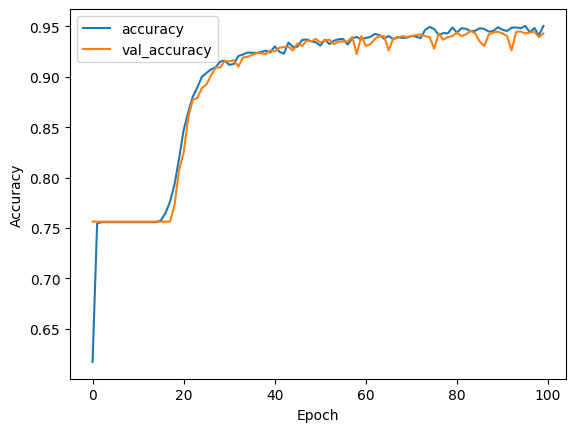

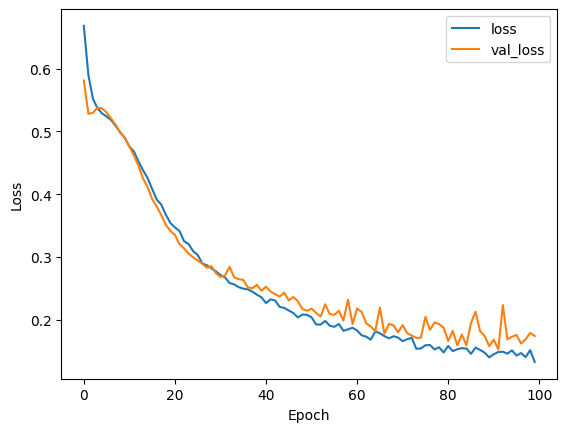

In [ ]:
# prompt: print the accuracy and loss curve of training and validation dataset

plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# prompt: save the history in the "/content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model/" location

history_df = pd.DataFrame(r.history)
history_df.to_csv(r'/content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model/base_SE_history.csv')


In [ ]:
model.save_weights("/content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model/final_model.h5")

In [ ]:
model.load_weights(r"/content/drive/MyDrive/_1_thermal_Image/_ablation_study/final_model/final_model.h5")


preds = model.evaluate_generator(test_set)
print ("Loss = ",float(preds[0]))
print ("Test Accuracy = ",float(preds[1])*100)

<ipython-input-15-31cb7c60f201>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  preds = model.evaluate_generator(test_set)


Loss =  0.04804270462633453
Test Accuracy =  95.19572953736655
